In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from rdkit import Chem, DataStructs
from rdkit.Chem import PandasTools, AllChem
from rdkit.Chem.rdmolops import GetAdjacencyMatrix
from torch_geometric.data import Data
import torch.nn.functional as F
import torch.nn as nn
from torch_geometric.nn import GCNConv, global_mean_pool
from torch_geometric.data import DataLoader as GeometricDataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import torch

In [2]:
df = pd.read_excel('1400.xlsx')
pretrain_data = pd.read_excel('35000.xlsx')

In [3]:
df = df.rename(columns = {'IC50, mmg/ml': "IC50"})
df_smiles = df[['IC50', 'SMILES']]

In [4]:
df_smiles.head(5)

,IC50,SMILES
0,2.7,OCC\N=C(\[C@]12C)C[C@@H](C1(C)C)CC2
1,0.7,OCC\N=C(\[C@]12C)C[C@@H](C1(C)C)CC2
2,9.9,CCN(CC)CC\N=C(\[C@@]12C)C[C@H](C1(C)C)CC2
3,8.3,CN(C)CC\N=C(\[C@@]12C)C[C@H](C1(C)C)CC2
4,39.4,CN(C)CC(=O)O[C@H]1C[C@H](CC2)C(C)(C)[C@@]12C


In [5]:
pretrain_data = pretrain_data.drop(columns = ['Unnamed: 0', 'Title'])

In [6]:
pretrain_data.head(5)

,IC50,SMILES
0,0.000015,[H]\N=C(N)\N[C@@H](C1)[C@@H](NC(=O)C)[C@@H](C=...
1,0.000016,O=C(O)C1=C[C@H](N)[C@@H](NC(=O)C)[C@@H](C1)COC...
2,0.000033,C=CC(=O)N[C@H]([C@H](C1)N)[C@@H](C=C1C([O-])=O...
3,0.000032,CC(=O)N[C@H]([C@H](C1)N)[C@@H](C=C1C([O-])=O)O...
4,0.000041,O=C(O)c1c(O)c(=O)cc([nH]1)-c(c2C)ccc(c2)-c3noc...


In [7]:
def one_hot_encoding(x, permitted_list):
    """
    Maps input elements x which are not in the permitted list to the last element
    of the permitted list.
    """
    if x not in permitted_list:
        x = permitted_list[-1]
    binary_encoding = [int(boolean_value) for boolean_value in list(map(lambda s: x == s, permitted_list))]
    return binary_encoding

In [8]:
def get_atom_features(atom, 
                      use_chirality = True, 
                      hydrogens_implicit = True):
    """
    Takes an RDKit atom object as input and gives a 1d-numpy array of atom features as output.
    """
    # define list of permitted atoms
    
    permitted_list_of_atoms =  ['C','N','O','S','F','Si','P','Cl','Br','Mg','Na','Ca','Fe','As','Al','I', 'B','V','K','Tl','Yb','Sb','Sn','Ag','Pd','Co','Se','Ti','Zn', 'Li','Ge','Cu','Au','Ni','Cd','In','Mn','Zr','Cr','Pt','Hg','Pb','Unknown']
    
    if hydrogens_implicit == False:
        permitted_list_of_atoms = ['H'] + permitted_list_of_atoms
    
    # compute atom features
    
    atom_type_enc = one_hot_encoding(str(atom.GetSymbol()), permitted_list_of_atoms)
    
    n_heavy_neighbors_enc = one_hot_encoding(int(atom.GetDegree()), [0, 1, 2, 3, 4, "MoreThanFour"])
    
    formal_charge_enc = one_hot_encoding(int(atom.GetFormalCharge()), [-3, -2, -1, 0, 1, 2, 3, "Extreme"])
    
    hybridisation_type_enc = one_hot_encoding(str(atom.GetHybridization()), ["S", "SP", "SP2", "SP3", "SP3D", "SP3D2", "OTHER"])
    
    is_in_a_ring_enc = [int(atom.IsInRing())]
    
    is_aromatic_enc = [int(atom.GetIsAromatic())]
    
    atomic_mass_scaled = [float((atom.GetMass() - 10.812)/116.092)]
    
    vdw_radius_scaled = [float((Chem.GetPeriodicTable().GetRvdw(atom.GetAtomicNum()) - 1.5)/0.6)]
    
    covalent_radius_scaled = [float((Chem.GetPeriodicTable().GetRcovalent(atom.GetAtomicNum()) - 0.64)/0.76)]
    atom_feature_vector = atom_type_enc + n_heavy_neighbors_enc + formal_charge_enc + hybridisation_type_enc + is_in_a_ring_enc + is_aromatic_enc + atomic_mass_scaled + vdw_radius_scaled + covalent_radius_scaled
                                    
    if use_chirality == True:
        chirality_type_enc = one_hot_encoding(str(atom.GetChiralTag()), ["CHI_UNSPECIFIED", "CHI_TETRAHEDRAL_CW", "CHI_TETRAHEDRAL_CCW", "CHI_OTHER"])
        atom_feature_vector += chirality_type_enc
    
    if hydrogens_implicit == True:
        n_hydrogens_enc = one_hot_encoding(int(atom.GetTotalNumHs()), [0, 1, 2, 3, 4, "MoreThanFour"])
        atom_feature_vector += n_hydrogens_enc
    return np.array(atom_feature_vector)

In [9]:
def get_bond_features(bond, 
                      use_stereochemistry = True):
    """
    Takes an RDKit bond object as input and gives a 1d-numpy array of bond features as output.
    """
    permitted_list_of_bond_types = [Chem.rdchem.BondType.SINGLE, Chem.rdchem.BondType.DOUBLE, Chem.rdchem.BondType.TRIPLE, Chem.rdchem.BondType.AROMATIC]
    bond_type_enc = one_hot_encoding(bond.GetBondType(), permitted_list_of_bond_types)
    
    bond_is_conj_enc = [int(bond.GetIsConjugated())]
    
    bond_is_in_ring_enc = [int(bond.IsInRing())]
    
    bond_feature_vector = bond_type_enc + bond_is_conj_enc + bond_is_in_ring_enc
    
    if use_stereochemistry == True:
        stereo_type_enc = one_hot_encoding(str(bond.GetStereo()), ["STEREOZ", "STEREOE", "STEREOANY", "STEREONONE"])
        bond_feature_vector += stereo_type_enc
    return np.array(bond_feature_vector)

In [10]:
def create_pytorch_geometric_graph_data_list_from_smiles_and_labels(x_smiles, y):
    """
    Inputs:
    
    x_smiles = [smiles_1, smiles_2, ....] ... a list of SMILES strings
    y = [y_1, y_2, ...] ... a list of numerial labels for the SMILES strings (such as associated pKi values)
    
    Outputs:
    
    data_list = [G_1, G_2, ...] ... a list of torch_geometric.data.Data objects which represent labeled molecular graphs that can readily be used for machine learning
    
    """
    
    data_list = []
    
    for (smiles, y_val) in zip(x_smiles, y):
        
        # convert SMILES to RDKit mol object
        mol = Chem.MolFromSmiles(smiles)
        # get feature dimensions
        n_nodes = mol.GetNumAtoms()
        n_edges = 2*mol.GetNumBonds()
        unrelated_smiles = "O=O"
        unrelated_mol = Chem.MolFromSmiles(unrelated_smiles)
        n_node_features = len(get_atom_features(unrelated_mol.GetAtomWithIdx(0)))
        n_edge_features = len(get_bond_features(unrelated_mol.GetBondBetweenAtoms(0,1)))
        # construct node feature matrix X of shape (n_nodes, n_node_features)
        X = np.zeros((n_nodes, n_node_features))
        for atom in mol.GetAtoms():
            X[atom.GetIdx(), :] = get_atom_features(atom)
            
        X = torch.tensor(X, dtype = torch.float)
        
        # construct edge index array E of shape (2, n_edges)
        (rows, cols) = np.nonzero(GetAdjacencyMatrix(mol))
        torch_rows = torch.from_numpy(rows.astype(np.int64)).to(torch.long)
        torch_cols = torch.from_numpy(cols.astype(np.int64)).to(torch.long)
        E = torch.stack([torch_rows, torch_cols], dim = 0)
        
        # construct edge feature array EF of shape (n_edges, n_edge_features)
        EF = np.zeros((n_edges, n_edge_features))
        
        for (k, (i,j)) in enumerate(zip(rows, cols)):
            
            EF[k] = get_bond_features(mol.GetBondBetweenAtoms(int(i),int(j)))
        
        EF = torch.tensor(EF, dtype = torch.float)
        
        # construct label tensor
        y_tensor = torch.tensor(np.array([y_val]), dtype = torch.float)
        
        # construct Pytorch Geometric data object and append to data list
        data_list.append(Data(x = X, edge_index = E, edge_attr = EF, y = y_tensor))
    return data_list

In [11]:
class GNNModel(torch.nn.Module):
    def __init__(self, node_input_dim, edge_input_dim, hidden_dim, output_dim):
        super(GNNModel, self).__init__()

        self.conv1 = GCNConv(node_input_dim, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, hidden_dim)

        self.fc1 = torch.nn.Linear(hidden_dim, hidden_dim//2)
        self.fc2 = torch.nn.Linear(hidden_dim//2, output_dim)

    def forward(self, data):
        x, edge_index, edge_attr = data.x, data.edge_index, data.edge_attr

        # GNN layers
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        x = F.relu(x)

        x = global_mean_pool(x, data.batch)

        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)

        return x

In [12]:
unrelated_smiles = "O=O"
unrelated_mol = Chem.MolFromSmiles(unrelated_smiles)

In [13]:
node_input_dim = len(get_atom_features(unrelated_mol.GetAtomWithIdx(0)))
edge_input_dim = len(get_bond_features(unrelated_mol.GetBondBetweenAtoms(0,1)))
hidden_dim = 64
output_dim = 1
gnn_model = GNNModel(node_input_dim, edge_input_dim, hidden_dim, output_dim)

# Pretrain

In [14]:
X = pretrain_data['SMILES'].tolist()
y = pretrain_data['IC50'].tolist()

In [15]:
data_list = create_pytorch_geometric_graph_data_list_from_smiles_and_labels(X, y)
train_data, val_data = train_test_split(data_list, test_size=0.2, random_state=42)

[13:03:43] Conflicting single bond directions around double bond at index 55.
[13:03:43]   BondStereo set to STEREONONE and single bond directions set to NONE.
[13:06:10] Conflicting single bond directions around double bond at index 7.
[13:06:10]   BondStereo set to STEREONONE and single bond directions set to NONE.


In [16]:
train_loader = GeometricDataLoader(dataset=train_data, batch_size=2**7, shuffle=True)
val_loader = GeometricDataLoader(dataset=val_data, batch_size=2**7)

/home/user/conda/envs/chem/lib/python3.9/site-packages/torch_geometric/deprecation.py:22: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


In [17]:
loss_function = nn.MSELoss()

In [18]:
optimiser = torch.optim.Adam(gnn_model.parameters(), lr=3e-4)

In [19]:
train_losses = []
val_losses = []

for epoch in range(35):
    gnn_model.train()

    train_loss = 0.0
    for batch in train_loader:
        output = gnn_model(batch)
        loss = loss_function(output[:, 0], torch.tensor(batch.y, dtype=torch.float32))

        optimiser.zero_grad()
        loss.backward()
        optimiser.step()

        train_loss += loss.item() * batch.num_graphs

    train_loss /= len(train_data)
    train_losses.append(train_loss)
    
    gnn_model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for batch in val_loader:
            output = gnn_model(batch)
            loss = loss_function(output[:, 0], torch.tensor(batch.y, dtype=torch.float32))
            val_loss += loss.item() * batch.num_graphs

    val_loss /= len(val_data)
    val_losses.append(val_loss)

    print(f"Epoch {epoch+1:03d} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")

/tmp/ipykernel_1837866/2643477154.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  loss = loss_function(output[:, 0], torch.tensor(batch.y, dtype=torch.float32))
/home/user/conda/envs/chem/lib/python3.9/site-packages/torch/autograd/__init__.py:251: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 11010). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at ../c10/cuda/CUDAFunctions.cpp:108.)
  Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
/tmp/ipykernel_1837866/2643477154.py:28: UserWarning: To copy construct fr

Epoch 001 | Train Loss: 2431.5472 | Val Loss: 2168.3543
Epoch 002 | Train Loss: 2396.2504 | Val Loss: 2163.7180
Epoch 003 | Train Loss: 2391.9881 | Val Loss: 2158.4320
Epoch 004 | Train Loss: 2387.1147 | Val Loss: 2152.7579
Epoch 005 | Train Loss: 2381.6555 | Val Loss: 2148.3458
Epoch 006 | Train Loss: 2376.7235 | Val Loss: 2141.3035
Epoch 007 | Train Loss: 2372.1219 | Val Loss: 2135.4293
Epoch 008 | Train Loss: 2367.9184 | Val Loss: 2131.5489
Epoch 009 | Train Loss: 2364.5694 | Val Loss: 2127.5906
Epoch 010 | Train Loss: 2361.8879 | Val Loss: 2123.9529
Epoch 011 | Train Loss: 2359.2993 | Val Loss: 2121.6086
Epoch 012 | Train Loss: 2357.1592 | Val Loss: 2120.3977
Epoch 013 | Train Loss: 2355.3271 | Val Loss: 2118.0592
Epoch 014 | Train Loss: 2354.4677 | Val Loss: 2117.5068
Epoch 015 | Train Loss: 2353.6344 | Val Loss: 2115.8208
Epoch 016 | Train Loss: 2351.8666 | Val Loss: 2114.5749
Epoch 017 | Train Loss: 2350.4138 | Val Loss: 2113.6140
Epoch 018 | Train Loss: 2349.0644 | Val Loss: 21

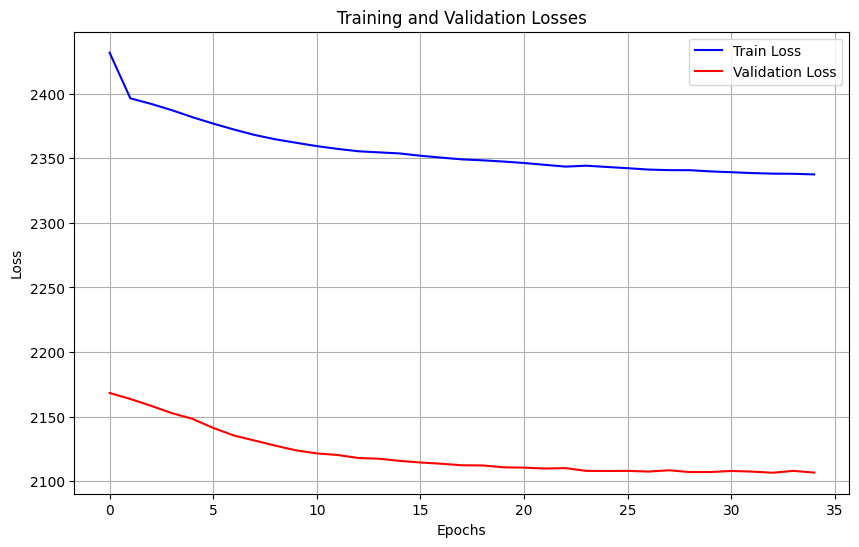

In [21]:
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Train Loss', color='blue')
plt.plot(val_losses, label='Validation Loss', color='red')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Losses')
plt.legend()
plt.grid(True)
plt.show()

In [22]:
torch.save(gnn_model.state_dict(), 'gnn_pretrain.pth')

# Using Pretrain

In [33]:
use_pretrain = True

In [34]:
gnn_model = GNNModel(node_input_dim, edge_input_dim, hidden_dim, output_dim)
if use_pretrain:
    gnn_model.load_state_dict(torch.load('gnn_pretrain.pth'))

In [35]:
x_smiles = df['SMILES'].tolist()
y = df['IC50'].tolist()

In [36]:
data_list = create_pytorch_geometric_graph_data_list_from_smiles_and_labels(x_smiles, y)
train_data, val_data = train_test_split(data_list, test_size=0.2, random_state=42)

[13:12:53] Conflicting single bond directions around double bond at index 55.
[13:12:53]   BondStereo set to STEREONONE and single bond directions set to NONE.


In [37]:
train_loader = GeometricDataLoader(dataset=train_data, batch_size=2**7, shuffle=True)
val_loader = GeometricDataLoader(dataset=val_data, batch_size=2**7)

In [38]:
loss_function = nn.MSELoss()

In [39]:
optimiser = torch.optim.Adam(gnn_model.parameters(), lr=1e-4)

In [40]:
train_losses = []
val_losses = []

for epoch in range(35):
    gnn_model.train()

    # Training
    train_loss = 0.0
    for batch in train_loader:
        output = gnn_model(batch)
        loss = loss_function(output[:, 0], torch.tensor(batch.y, dtype=torch.float32))

        optimiser.zero_grad()
        loss.backward()
        optimiser.step()

        train_loss += loss.item() * batch.num_graphs

    train_loss /= len(train_data)
    train_losses.append(train_loss)
    
    # Validation
    gnn_model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for batch in val_loader:
            output = gnn_model(batch)
            loss = loss_function(output[:, 0], torch.tensor(batch.y, dtype=torch.float32))
            val_loss += loss.item() * batch.num_graphs

    val_loss /= len(val_data)
    val_losses.append(val_loss)

    # Logging
    print(f"Epoch {epoch+1:03d} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")

/tmp/ipykernel_1837866/2643477154.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  loss = loss_function(output[:, 0], torch.tensor(batch.y, dtype=torch.float32))
/tmp/ipykernel_1837866/2643477154.py:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  loss = loss_function(output[:, 0], torch.tensor(batch.y, dtype=torch.float32))


Epoch 001 | Train Loss: 10833.8298 | Val Loss: 5335.2857
Epoch 002 | Train Loss: 10760.7755 | Val Loss: 5289.2640
Epoch 003 | Train Loss: 10683.4803 | Val Loss: 5249.2656
Epoch 004 | Train Loss: 10616.3355 | Val Loss: 5207.0181
Epoch 005 | Train Loss: 10544.9333 | Val Loss: 5167.8196
Epoch 006 | Train Loss: 10475.9737 | Val Loss: 5131.5139
Epoch 007 | Train Loss: 10411.4010 | Val Loss: 5100.2380
Epoch 008 | Train Loss: 10353.9280 | Val Loss: 5071.6939
Epoch 009 | Train Loss: 10299.0760 | Val Loss: 5048.6557
Epoch 010 | Train Loss: 10249.2282 | Val Loss: 5030.2244
Epoch 011 | Train Loss: 10207.7990 | Val Loss: 5013.7236
Epoch 012 | Train Loss: 10163.7344 | Val Loss: 5000.9189
Epoch 013 | Train Loss: 10121.0301 | Val Loss: 4990.9792
Epoch 014 | Train Loss: 10084.3638 | Val Loss: 4983.4473
Epoch 015 | Train Loss: 10053.4891 | Val Loss: 4978.9158
Epoch 016 | Train Loss: 10023.3637 | Val Loss: 4975.9566
Epoch 017 | Train Loss: 9998.8739 | Val Loss: 4974.0349
Epoch 018 | Train Loss: 9976.013

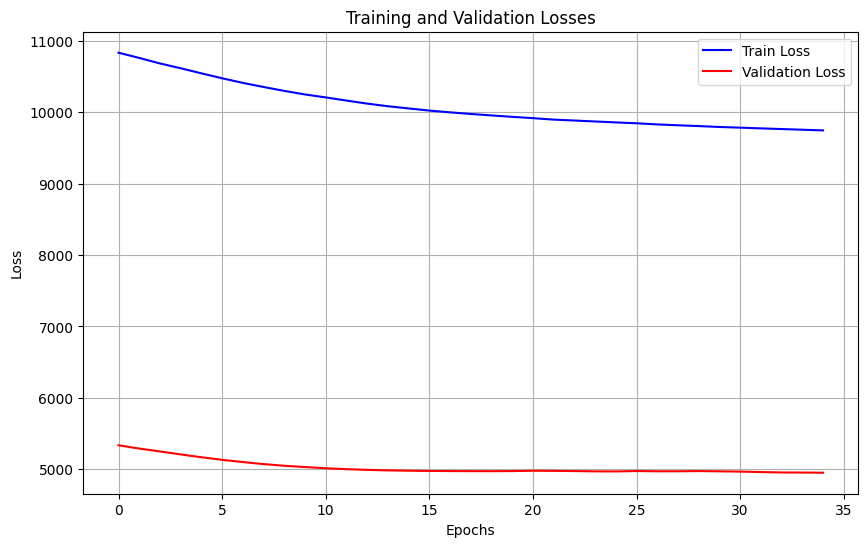

In [41]:
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Train Loss', color='blue')
plt.plot(val_losses, label='Validation Loss', color='red')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Losses')
plt.legend()
plt.grid(True)
plt.show()